In [78]:
# Preparation
import matplotlib.pyplot as plt
import numpy as np
import math

from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RXGate

In [353]:
# Helper Functions 

def get_histogram(qc, shots=5000):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=shots)
    result = job.result()
    return result.get_counts()

# Norm(0, 1)
def norm(x):
    return (1/sqrt(2*pi))*np.exp(-x**2/2) 


## Grover-Rudolph Wavefunction Preparation
This function takes as input a log-concave distribution and encodes it into an n qubit circuit. 

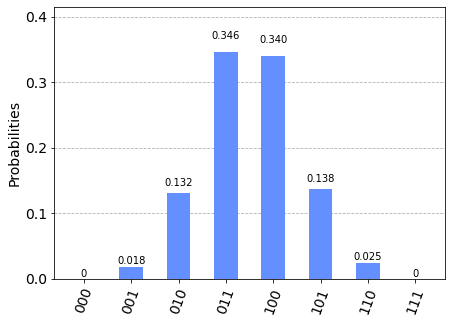

In [364]:
def GRA(n, dist, a, b):
    """
    Grover Rudolph Wavefunction Preparation
    
    n: Number of qubits (precision)
    dist: Distribution (must be log-concave)
    a, b: Range of distribution
    """
    R = b - a
    F = []     # cos^2(angle) vector
    T = []     # Angle vector
    P = []     # Probability vector
    
    # Prepare the necessary vectors
    for m in range(0,n+1):
        F.append([])
        T.append([])
        P.append([])
        for i in range(0, 2**m):
            # Append array of size i to f
            num_LB = a + (R / 2**m) * i       # Numerator lower bound
            num_UB = num_LB + (R / 2**(m+1))  # Numerator upper bound
            den_LB = a + (R / 2**m) * i       # Denominator lower bound
            den_UB = a + (R / 2**m) * (i+1)   # Denominator lower bound
            f = integrate.quad(dist, num_LB, num_UB)[0] / integrate.quad(dist, den_LB, den_UB)[0]
            t = arccos(sqrt(f))
            p = integrate.quad(dist, den_LB, den_UB)[0]
            F[m].append(f)
            T[m].append(t)
            P[m].append(p)
            
    # Construct the circuit
    qr = QuantumRegister(n,'q')
    cr = ClassicalRegister(n,'c')
    qc = QuantumCircuit(qr, cr)
    
    qc.rx(2*T[0][0], 0)
    for m in range(1, n):
        qc.barrier()
        control_qubits = []
        for i in range(0, m):
            control_qubits.append(qr[i])
        for i in range(0, 2**m):
            for j in range(0, m):
                if i & (2**j) == False:
                    qc.x(j)
            qc.barrier()
            qc.mcrx(2*T[m][i], control_qubits, qr[m])
            qc.barrier()
            for j in range(0, m):
                if i & (2**j) == False:
                    qc.x(j)
                    
    for m in reversed(range(1,n)):
        qc.swap(m-1, m)
    return qc

n=3
qc = GRA(n, norm, -4, 4)
qr = QuantumRegister(n,'q')
cr = ClassicalRegister(n,'c')
qc.measure(qr,cr)
plot_histogram(get_histogram(qc))
# qc.draw()

## Step 1. Creating the initial state

In [1]:
def binary_approx(n, k):
    """
    
    Input:
        n: real number between 0 and 1
        k: the number of bits use to approximate n
        
    Output: 
        a: a list such that the i-th element is 1 or 0
    """
    a = []
    total = 0
    for i in range(1, k+1):
        bit = 0
        if (n > total + 1/2**i): 
            bit = 1
        else:
            bit = 0
        a.append(bit)
        total += bit/2**i
    return (a, total)

alpha_register = QuantumRegister(k, 'alpha')

mu_register = QuantumRegister(mu_size, 'mu')
sigma_register = QuantumRegister(sigma_size, 'sigma')
N_register = QuantumRegister(N, 'n')
res_register = QuantumRegister(N, 'result')

qc = QuantumCircuit(alpha_register, mu_register, sigma_register, N_register, res_register)
qc.draw()

NameError: name 'QuantumRegister' is not defined

## Step 2. Compute $\alpha$

The angle $\alpha$ is defined as

$$\alpha = \cos^{-1}\left(\sqrt{\frac{f(\mu/2, \sigma/2)}{f(\mu, \sigma)}}\right). \tag{12}$$

The function $f$ is the normalization factor defined as follows: 

$$f(\mu, \sigma) = \sum_{n=-\infty}^{\infty} e^{-\frac{(n-\mu)^2}{\sigma^2}}. \tag{7}$$

To input the value $\alpha$ into our quantum circuit, we need to approximate this number using the number of qubits we have. Since $0 \leq \alpha \leq 2\pi$, we can approximate this number using k-digits of binary notation given by the formula $\frac{\alpha}{2\pi} \approx \sum_{i=1}^k \frac{a_i}{2^i}$ that gives us the digits we need to approximate $\alpha$ as $\alpha \approx \sum_{i=1}^k \pi\frac{a_i}{2^{i-1}}$. Here, $a_i$ takes the values either 0 or 1. This binary notation gives us a way to implement the rotation operator as a sequence of $k$ standard rotations as 
$$R(\alpha) \approx R(\pi/2^{k-1})^{\alpha_k}\cdots R(\pi/2^2)^{\alpha_2}R(\pi/2)^{\alpha_1}$$

The following block implements some routines to implement the functions needed to create $\alpha$. 

In [4]:
def f(mu, sigma, n):
    return np.sum(np.exp((-(np.arange(-n, n+1, 1) - mu)**2)/float(sigma**2)))

def angle(mu, sigma, n=1000):
    return np.arccos(math.sqrt(f(mu/2, sigma/2, n)/ f(mu, sigma, n)))

# Example code to verify correctness
alpha = angle(mu, sigma)/(np.pi*2)
precision = 6

(alpha_binary, alpha_approx) = binary_approx(alpha, precision)

print(alpha)
print(alpha_approx)
print(alpha_binary)

0.11143872044136584
0.109375
[0, 0, 0, 1, 1, 1]


## Step 3. Apply the rotation $\alpha$ on $q_0$

This gives us the super position state 
$$\left|\alpha \right>\left|\mu, \sigma, N\right> \left|0^{N-1}\right>\otimes (\cos(\alpha)\left|0\right> + \sin(\alpha)\left|1\right>)$$


In [261]:
import scipy.integrate as integrate
import scipy.special as special

import numpy as np
from numpy import sqrt, sin, cos, pi, arccos


# Normal distribution
def integrand(x):
    return (1/sqrt(2*pi))*np.exp(-x**2/2) 

# Step 1: m = 1, i = [0, 1]
(p1_0, e) = integrate.quad(integrand, -4, 0)
(p1_1, e) = integrate.quad(integrand, 0, 4)
print()
print (p1_0)
print (p1_1)
print()

f1_0 = sqrt( integrate.quad(integrand, -4, -2)[0] / integrate.quad(integrand, -4, 0)[0] )
f1_1 = sqrt( integrate.quad(integrand, 0, 2)[0] / integrate.quad(integrand, 0, 4)[0] )

print()
print ("f")
print (f1_0)
print (f1_1)
print()

f2_00 = sqrt( integrate.quad(integrand, -4, -3)[0] / integrate.quad(integrand, -4, -2)[0] )
f2_01 = sqrt( integrate.quad(integrand, -2, -1)[0] / integrate.quad(integrand, -2, 0)[0] )
f2_10 = sqrt( integrate.quad(integrand, 0, 1)[0] / integrate.quad(integrand, 0, 2)[0] )
f2_11 = sqrt( integrate.quad(integrand, 2, 3)[0] / integrate.quad(integrand, 2, 4)[0] )

t1_0 = arccos(f1_0)
t1_1 = arccos(f1_1)

t2_00 = arccos(f2_00)
t2_01 = arccos(f2_01)
t2_10 = arccos(f2_10)
t2_11 = arccos(f2_11)

p2_00 = ((cos(t1_0)*sqrt(p1_0))**2)  # Region 00
p2_01 = ((sin(t1_0)*sqrt(p1_0))**2)  # Region 01
p2_10 = ((cos(t1_1)*sqrt(p1_1))**2)  # Region 10
p2_11 = ((sin(t1_1)*sqrt(p1_1))**2)  # Region 11
print()
print (p2_00)  # Region 00
print (p2_01)  # Region 01
print (p2_10)  # Region 10
print (p2_11)  # Region 11
print()

p3_000 = ((cos(t2_00)*sqrt(p2_00))**2)  # Region 000
p3_001 = ((sin(t2_00)*sqrt(p2_00))**2)  # Region 001
p3_010 = ((cos(t2_01)*sqrt(p2_01))**2)  # Region 010
p3_011 = ((sin(t2_01)*sqrt(p2_01))**2)  # Region 011
p3_100 = ((cos(t2_10)*sqrt(p2_10))**2)  # Region 100
p3_101 = ((sin(t2_10)*sqrt(p2_10))**2)  # Region 101
p3_110 = ((cos(t2_11)*sqrt(p2_11))**2)  # Region 110
p3_111 = ((sin(t2_11)*sqrt(p2_11))**2)  # Region 111
print()
print (p3_000)  # Region 000
print (p3_001)  # Region 001
print (p3_010)  # Region 010
print (p3_011)  # Region 011
print (p3_100)  # Region 100
print (p3_101)  # Region 101
print (p3_110)  # Region 110
print (p3_111)  # Region 111
print()




0.49996832875816694
0.49996832875816694


f
0.21316613164961587
0.9770159672787024


0.02271846070634609
0.47724986805182074
0.47724986805182074
0.02271846070634613


0.0013182267897969737
0.02140023391654911
0.1359051219832778
0.34134474606854287
0.34134474606854287
0.1359051219832778
0.02140023391654915
0.0013182267897969783



In [240]:
# Testing manually

num_qubits = 3

qr = QuantumRegister(num_qubits,'q')
cr = ClassicalRegister(num_qubits,'c')

qc = QuantumCircuit(qr, cr)
qc.rx(pi/2, 0)
qc.barrier()

qc.x(0)
qc.crx(2*t1_0, 0, 1)
qc.x(0)
qc.crx(2*t1_1, 0, 1)
qc.barrier()

qc.x(0)
qc.x(1)
qc.mcrx(2*t2_00, [qr[0],qr[1]], qr[2])
qc.x(0)
qc.mcrx(2*t2_01, [qr[0],qr[1]], qr[2])
qc.x(1)
qc.x(0)
qc.mcrx(2*t2_10, [qr[0],qr[1]], qr[2])
qc.x(0)
qc.mcrx(2*t2_11, [qr[0],qr[1]], qr[2])
qc.barrier()

qc.swap(1, 2)
qc.swap(0, 1)

qc.draw()


┌─────────┐ ░ ┌───┐             ┌───┐                ░ ┌───┐»
q_0: ┤ RX(π/2) ├─░─┤ X ├──────■──────┤ X ├───────■────────░─┤ X ├»
     └─────────┘ ░ └───┘┌─────┴─────┐└───┘┌──────┴──────┐ ░ ├───┤»
q_1: ────────────░──────┤ RX(2.712) ├─────┤ RX(0.42963) ├─░─┤ X ├»
                 ░      └───────────┘     └─────────────┘ ░ └───┘»
q_2: ────────────░────────────────────────────────────────░──────»
                 ░                                        ░      »
c: 3/════════════════════════════════════════════════════════════»
                                                                 »
«                             ┌───┐                         ┌───┐»
«q_0: ────────────────────────┤ X ├────────────■────────────┤ X ├»
«                             └─┬─┘            │            └─┬─┘»
«q_1: ───────────■──────────────■──────────────┼──────────────■──»
«     ┌──────────┴───────────┐     ┌───────────┴───────────┐     »
«q_2: ┤ U(1.3275,-π/2,π/2,0) ├─────┤ U(-1.3275,-π/2,π/2,0) ├─────»
«     └──────────────────────┘     └───────────────────────┘     »
«c: 3/═══════════════════════════════════════════════════════════»
«                                                                »
«                                      ┌───┐          ┌───┐»
«q_0: ───────────■─────────────────────┤ X ├──────────┤ X ├»
«                │                     └───┘          └─┬─┘»
«q_1: ───────────┼───────────────────────■──────────────■──»
«     ┌──────────┴───────────┐┌──────────┴───────────┐     »
«q_2: ┤ U(1.3275,-π/2,π/2,0) ├┤ U(1.0079,-π/2,π/2,0) ├─────»
«     └──────────────────────┘└──────────────────────┘     »
«c: 3/═════════════════════════════════════════════════════»
«                                                          »
«                              ┌───┐                        ┌───┐»
«q_0: ────────────■────────────┤ X ├───────────■────────────┤ X ├»
«                 │            └─┬─┘           │            ├───┤»
«q_1: ────────────┼──────────────■─────────────┼────────────┤ X ├»
«     ┌───────────┴───────────┐     ┌──────────┴───────────┐└───┘»
«q_2: ┤ U(-1.0079,-π/2,π/2,0) ├─────┤ U(1.0079,-π/2,π/2,0) ├─────»
«     └───────────────────────┘     └──────────────────────┘     »
«c: 3/═══════════════════════════════════════════════════════════»
«                                                                »
«                              ┌───┐                          ┌───┐»
«q_0: ─────────────────────────┤ X ├────────────■─────────────┤ X ├»
«                              └─┬─┘            │             └─┬─┘»
«q_1: ────────────■──────────────■──────────────┼───────────────■──»
«     ┌───────────┴───────────┐     ┌───────────┴────────────┐     »
«q_2: ┤ U(0.56289,-π/2,π/2,0) ├─────┤ U(-0.56289,-π/2,π/2,0) ├─────»
«     └───────────────────────┘     └────────────────────────┘     »
«c: 3/═════════════════════════════════════════════════════════════»
«                                                                  »
«                                        ┌───┐          ┌───┐»
«q_0: ────────────■──────────────────────┤ X ├──────────┤ X ├»
«                 │                      └───┘          └─┬─┘»
«q_1: ────────────┼────────────────────────■──────────────■──»
«     ┌───────────┴───────────┐┌───────────┴───────────┐     »
«q_2: ┤ U(0.56289,-π/2,π/2,0) ├┤ U(0.24328,-π/2,π/2,0) ├─────»
«     └───────────────────────┘└───────────────────────┘     »
«c: 3/═══════════════════════════════════════════════════════»
«                                                            »
«                               ┌───┐                          ░       
«q_0: ────────────■─────────────┤ X ├────────────■─────────────░─────X─
«                 │             └─┬─┘            │             ░     │ 
«q_1: ────────────┼───────────────■──────────────┼─────────────░──X──X─
«     ┌───────────┴────────────┐     ┌───────────┴───────────┐ ░  │    
«q_2: ┤ U(-0.24328,-π/2,π/2,0) ├─────┤ U(0.24328,-π/2,π/2,0) ├─░──X────
«     └────────────────────

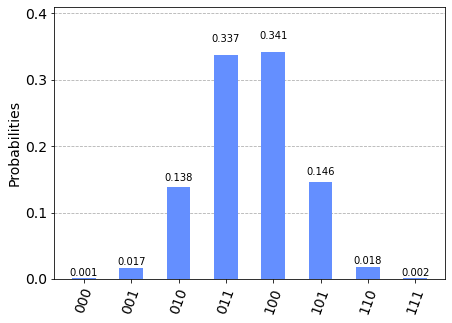

In [242]:
qc.measure(qr,cr)
plot_histogram(get_histogram(qc))

Notes: Fourier transform of the momentum operator is the position operator.